<a href="https://colab.research.google.com/github/deepshikhaa07/Facial-Emotion-Recognition-Using-Deep-Learning/blob/main/DLP_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import dataset



In [1]:
import zipfile
import os

with zipfile.ZipFile("fer2013.zip", 'r') as zip_ref:
    zip_ref.extractall("fer2013")

# Set directory paths
train_dir = "fer2013/train"
test_dir = "fer2013/test"

## Data processing

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

# Grayscale generators for Basic CNN
gray_train_gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True)
gray_test_gen = ImageDataGenerator(rescale=1./255)

gray_train_data = gray_train_gen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), color_mode='grayscale',
    batch_size=batch_size, class_mode='categorical', shuffle=True)

gray_test_data = gray_test_gen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), color_mode='grayscale',
    batch_size=batch_size, class_mode='categorical', shuffle=False)

# RGB generators for pretrained models
rgb_train_data = gray_train_gen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), color_mode='rgb',
    batch_size=batch_size, class_mode='categorical', shuffle=True)

rgb_test_data = gray_test_gen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), color_mode='rgb',
    batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(gray_train_data.class_indices)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Basic CNN Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(gray_train_data, epochs=10, validation_data=gray_test_data)

#  Save model
cnn_model.save("basic_cnn_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.2597 - loss: 1.7947 - val_accuracy: 0.3968 - val_loss: 1.5968
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3661 - loss: 1.6274 - val_accuracy: 0.4592 - val_loss: 1.4379
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.4262 - loss: 1.5000 - val_accuracy: 0.4855 - val_loss: 1.3465
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4518 - loss: 1.4280 - val_accuracy: 0.5004 - val_loss: 1.3146
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.4867 - loss: 1.3615 - val_accuracy: 0.5293 - val_loss: 1.2327
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.4987 - loss: 1.3182 - val_accuracy: 0.5375 - val_loss: 1.2108
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5070 - loss: 1.3026 - val_accuracy: 0.5319 - val_loss: 1.2015
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5110 - loss: 1.2821 - 

## EfficientNetB0 Model

In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base = EfficientNetB0(include_top=False, input_shape=(48, 48, 3), weights='imagenet')
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)
eff_model = Model(inputs=base.input, outputs=out)

eff_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
eff_history = eff_model.fit(rgb_train_data, epochs=10, validation_data=rgb_test_data)

# Save model
eff_model.save("efficientnet_model.h5")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 168s 198ms/step - accuracy: 0.3063 - loss: 1.8212 - val_accuracy: 0.2474 - val_loss: 1.8285
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4856 - loss: 1.3492 - val_accuracy: 0.2471 - val_loss: 1.9853
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.5376 - loss: 1.2271 - val_accuracy: 0.1404 - val_loss: 1.9517
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.5637 - loss: 1.1685 - val_accuracy: 0.1943 - val_loss: 1.8769
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5764 - loss: 1.1318 - val_accuracy: 0.1785 - val_loss: 2.1063
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.5858 - loss: 1.0884 - val_accuracy: 0.2246 - val_loss: 1.8390
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6142 - loss: 1.0472 - val_accuracy: 0.2619 - val_loss: 2.4689
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━

## ResNet50 Model

In [5]:
from tensorflow.keras.applications import ResNet50

base = ResNet50(include_top=False, input_shape=(48, 48, 3), weights='imagenet')
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)
resnet_model = Model(inputs=base.input, outputs=out)

resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet_model.fit(rgb_train_data, epochs=10, validation_data=rgb_test_data)

# Save model
resnet_model.save("resnet50_model.h5")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 138s 167ms/step - accuracy: 0.3070 - loss: 2.1431 - val_accuracy: 0.1817 - val_loss: 1.9416
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.4498 - loss: 1.4968 - val_accuracy: 0.4033 - val_loss: 2.0947
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.4911 - loss: 1.3556 - val_accuracy: 0.5274 - val_loss: 1.2510
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5157 - loss: 1.2922 - val_accuracy: 0.4476 - val_loss: 1.4022
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.5169 - loss: 1.3053 - val_accuracy: 0.4741 - val_loss: 1.6504
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5361 - loss: 1.2397 - val_accuracy: 0.3725 - val_loss: 1.6270
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.5559 - loss: 1.1878 - val_accuracy: 0.4553 - val_loss: 1.4967
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━

## MobileNetV2

In [6]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(include_top=False, input_shape=(48, 48, 3), weights='imagenet')
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)
mobile_model = Model(inputs=base.input, outputs=out)

mobile_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
mobile_history = mobile_model.fit(rgb_train_data, epochs=10, validation_data=rgb_test_data)

# Save model
mobile_model.save("mobilenetv2_model.h5")


<ipython-input-6-85fdc00c2627>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_shape=(48, 48, 3), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 145ms/step - accuracy: 0.2835 - loss: 1.9516 - val_accuracy: 0.3054 - val_loss: 5.1802
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 98s 93ms/step - accuracy: 0.3904 - loss: 1.6574 - val_accuracy: 0.3185 - val_loss: 2.8411
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.4108 - loss: 1.5988 - val_accuracy: 0.2690 - val_loss: 4.7954
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.4269 - loss: 1.5571 - val_accuracy: 0.3008 - val_loss: 4.3165
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.4614 - loss: 1.4286 - val_accuracy: 0.4570 - val_loss: 1.8841
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.4936 - loss: 1.3403 - val_accuracy: 0.4923 - val_loss: 1.7330
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5149 - loss: 1.2779 - val_accuracy: 0.4946 - val_loss: 1.9496
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━

## Evaluation of Models

In [7]:
# Evaluate accuracy
cnn_loss, cnn_acc = cnn_model.evaluate(gray_test_data)
eff_loss, eff_acc = eff_model.evaluate(rgb_test_data)
resnet_loss, resnet_acc = resnet_model.evaluate(rgb_test_data)
mobile_loss, mobile_acc = mobile_model.evaluate(rgb_test_data)

print(f"CNN Accuracy: {cnn_acc:.2f}")
print(f"EfficientNet Accuracy: {eff_acc:.2f}")
print(f"ResNet50 Accuracy: {resnet_acc:.2f}")
print(f"MobileNetV2 Accuracy: {mobile_acc:.2f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5035 - loss: 1.2542
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2178 - loss: 2.3534
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4963 - loss: 1.3677
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4383 - loss: 3.9122
CNN Accuracy: 0.55
EfficientNet Accuracy: 0.26
ResNet50 Accuracy: 0.56
MobileNetV2 Accuracy: 0.48


## Visualisation

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


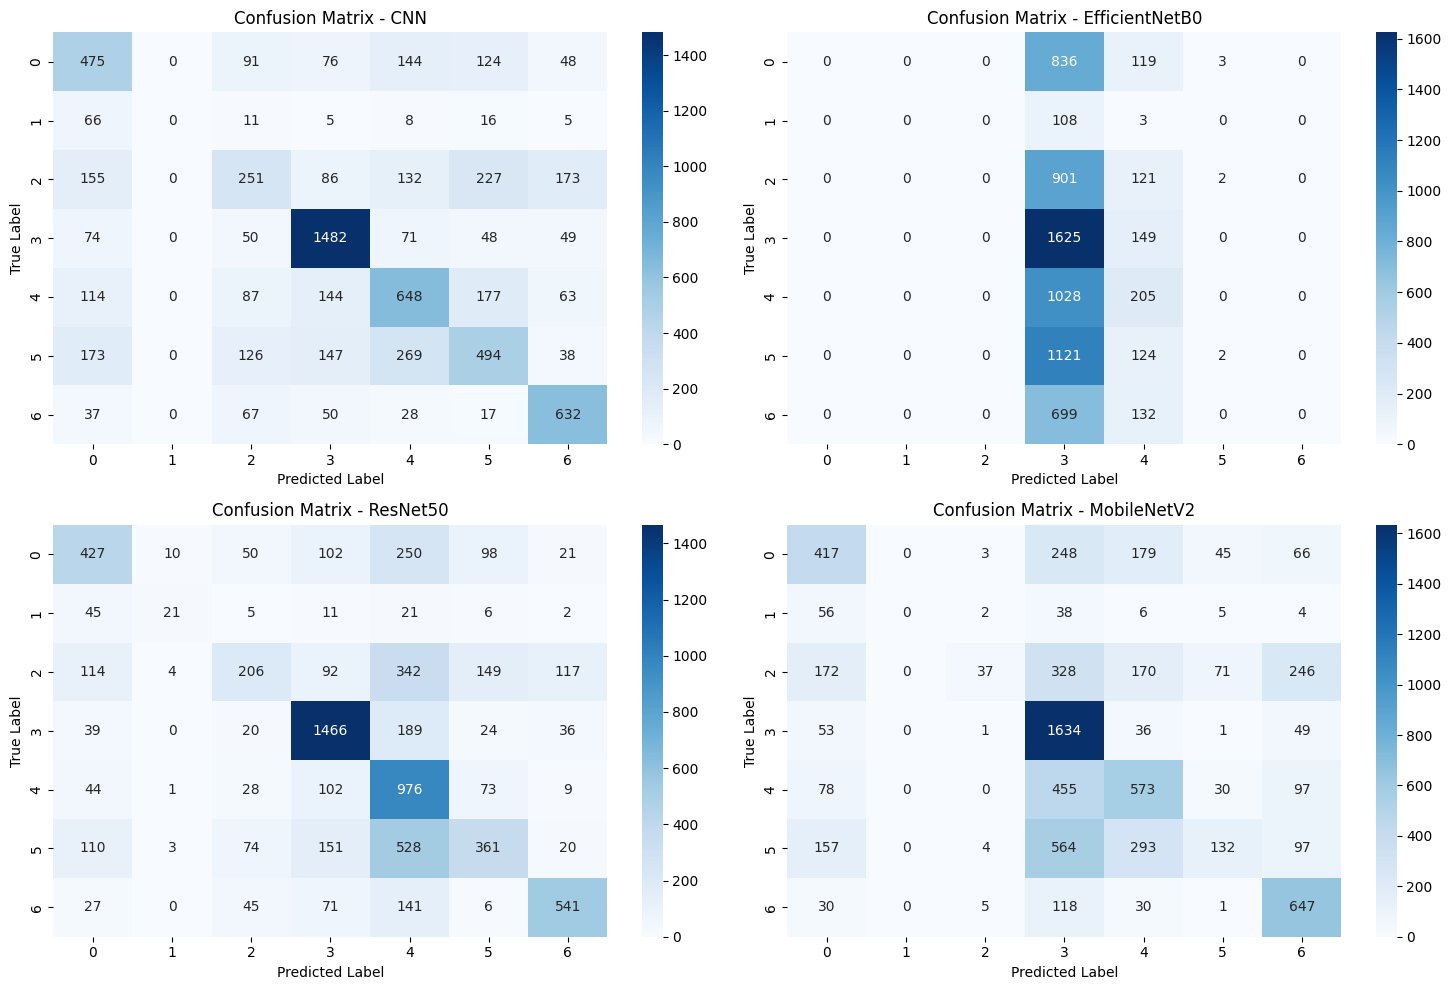

In [8]:
# Evaluate confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


models = [cnn_model, eff_model, resnet_model, mobile_model]
test_data = [gray_test_data, rgb_test_data, rgb_test_data, rgb_test_data]
model_names = ['CNN', 'EfficientNetB0', 'ResNet50', 'MobileNetV2']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (model, data, name) in enumerate(zip(models, test_data, model_names)):
    y_pred = model.predict(data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = data.classes
    cm = confusion_matrix(y_true, y_pred_classes)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [9]:
# Evaluate classification report

from sklearn.metrics import classification_report

for model, data, name in zip(models, test_data, model_names):
    y_pred = model.predict(data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = data.classes
    report = classification_report(y_true, y_pred_classes, target_names=data.class_indices.keys())
    print(f"Classification Report - {name}:\n{report}\n")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Classification Report - CNN:
              precision    recall  f1-score   support

       angry       0.43      0.50      0.46       958
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.25      0.29      1024
       happy       0.74      0.84      0.79      1774
     neutral       0.50      0.53      0.51      1233
         sad       0.45      0.40      0.42      1247
    surprise       0.63      0.76      0.69       831

    accuracy                           0.55      7178
   macro avg       0.45      0.47      0.45      7178
weighted avg       0.53      0.55      0.54      7178


  4/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report - EfficientNetB0:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.26      0.92      0.40      1774
     neutral       0.24      0.17      0.20      1233
         sad       0.29      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.26      7178
   macro avg       0.11      0.15      0.09      7178
weighted avg       0.15      0.26      0.13      7178


  3/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report - ResNet50:
              precision    recall  f1-score   support

       angry       0.53      0.45      0.48       958
     disgust       0.54      0.19      0.28       111
        fear       0.48      0.20      0.28      1024
       happy       0.73      0.83      0.78      1774
     neutral       0.40      0.79      0.53      1233
         sad       0.50      0.29      0.37      1247
    surprise       0.73      0.65      0.69       831

    accuracy                           0.56      7178
   macro avg       0.56      0.48      0.49      7178
weighted avg       0.57      0.56      0.54      7178


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Classification Report - MobileNetV2:
              precision    recall  f1-score   support

       angry       0.43      0.44      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.71      0.04      0.07      1024
       happy       0.48      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Prediction

In [23]:
# prediction

from tensorflow.keras.preprocessing import image
import numpy as np

def predict_emotion(img_path, model, class_indices):
    # Load the image with the correct color mode based on the model
    if model == cnn_model:  # Use grayscale for cnn_model
        img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    else:  # Use RGB for other models
        img = image.load_img(img_path, target_size=(48, 48), color_mode='rgb')

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    emotion = list(class_indices.keys())[predicted_class]
    return emotion

In [24]:
# prediction by other models

input_img_path = '/content/fer2013/test/angry/PrivateTest_10131363.jpg'
predicted_emotion = predict_emotion(input_img_path, eff_model, rgb_train_data.class_indices)
print(f"Predicted Emotion by Efficient Model: {predicted_emotion}")

input_img_path = '/content/fer2013/test/angry/PrivateTest_10131363.jpg'
predicted_emotion = predict_emotion(input_img_path, resnet_model, rgb_train_data.class_indices)
print(f"Predicted Emotion by ResNet50 Model: {predicted_emotion}")

input_img_path = '/content/fer2013/test/angry/PrivateTest_10131363.jpg'
predicted_emotion = predict_emotion(input_img_path, mobile_model, rgb_train_data.class_indices)
print(f"Predicted Emotion by MobileNet Model: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Emotion by Efficient Model: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Emotion by ResNet50 Model: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Emotion by MobileNet Model: sad


In [25]:
# prediction by basic cnn model

input_img_path = '/content/fer2013/test/angry/PrivateTest_10131363.jpg'
predicted_emotion = predict_emotion(input_img_path, cnn_model, gray_train_data.class_indices)
print(f"Predicted Emotion by Basic CNN Model: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicted Emotion by Basic CNN Model: happy
